In [4]:
!pip install pymc
!pip install aesara

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0]   -4.343  0.514  -5.366   -3.402      0.010    0.009    2718.0   
betas[1]   -0.076  0.715  -1.376    1.306      0.014    0.011    2550.0   
betas[2]    0.021  0.587  -1.128    1.089      0.011    0.009    2813.0   
betas[3]    0.206  0.678  -1.097    1.441      0.014    0.010    2262.0   
betas[4]    0.019  0.589  -1.115    1.094      0.011    0.009    2745.0   
...           ...    ...     ...      ...        ...      ...       ...   
theta[166]  0.042  0.121   0.000    0.224      0.002    0.005    3788.0   
theta[167]  0.026  0.022   0.001    0.065      0.000    0.001    4215.0   
theta[168]  0.034  0.039   0.000    0.102      0.001    0.001    3111.0   
theta[169]  0.025  0.023   0.001    0.065      0.000    0.001    3439.0   
theta[170]  0.032  0.045   0.000    0.106      0.001    0.002    3317.0   

            ess_tail  r_hat  
betas[0]      2283.0    1.0  
betas[1]      2441.0    1.0  
betas[2] 

/opt/conda/lib/python3.11/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (181) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'betas\n0'}>,
        <Axes: title={'center': 'betas\n1'}>,
        <Axes: title={'center': 'betas\n2'}>,
        <Axes: title={'center': 'betas\n3'}>],
       [<Axes: title={'center': 'betas\n4'}>,
        <Axes: title={'center': 'betas\n5'}>,
        <Axes: title={'center': 'betas\n6'}>,
        <Axes: title={'center': 'betas\n7'}>],
       [<Axes: title={'center': 'betas\n8'}>,
        <Axes: title={'center': 'betas\n9'}>,
        <Axes: title={'center': 'theta\n0'}>,
        <Axes: title={'center': 'theta\n1'}>],
       [<Axes: title={'center': 'theta\n2'}>,
        <Axes: title={'center': 'theta\n3'}>,
        <Axes: title={'center': 'theta\n4'}>,
        <Axes: title={'center': 'theta\n5'}>],
       [<Axes: title={'center': 'theta\n6'}>,
        <Axes: title={'center': 'theta\n7'}>,
        <Axes: title={'center': 'theta\n8'}>,
        <Axes: title={'center': 'theta\n9'}>],
       [<Axes: title={'center': 'theta\n10'}>,
        <Axes: title={'cente

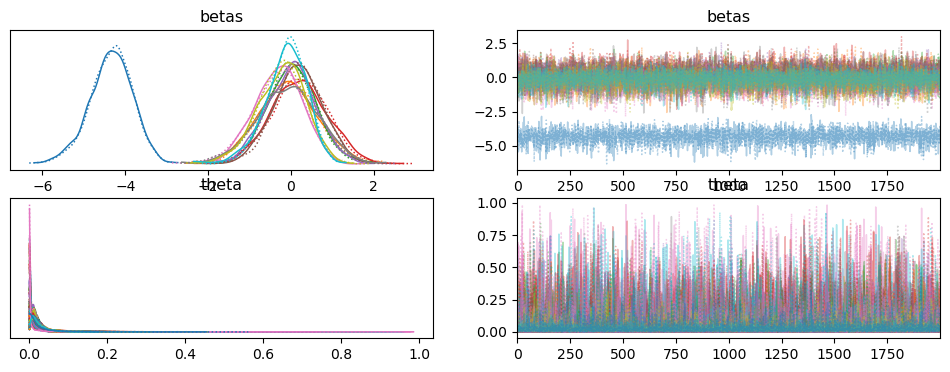

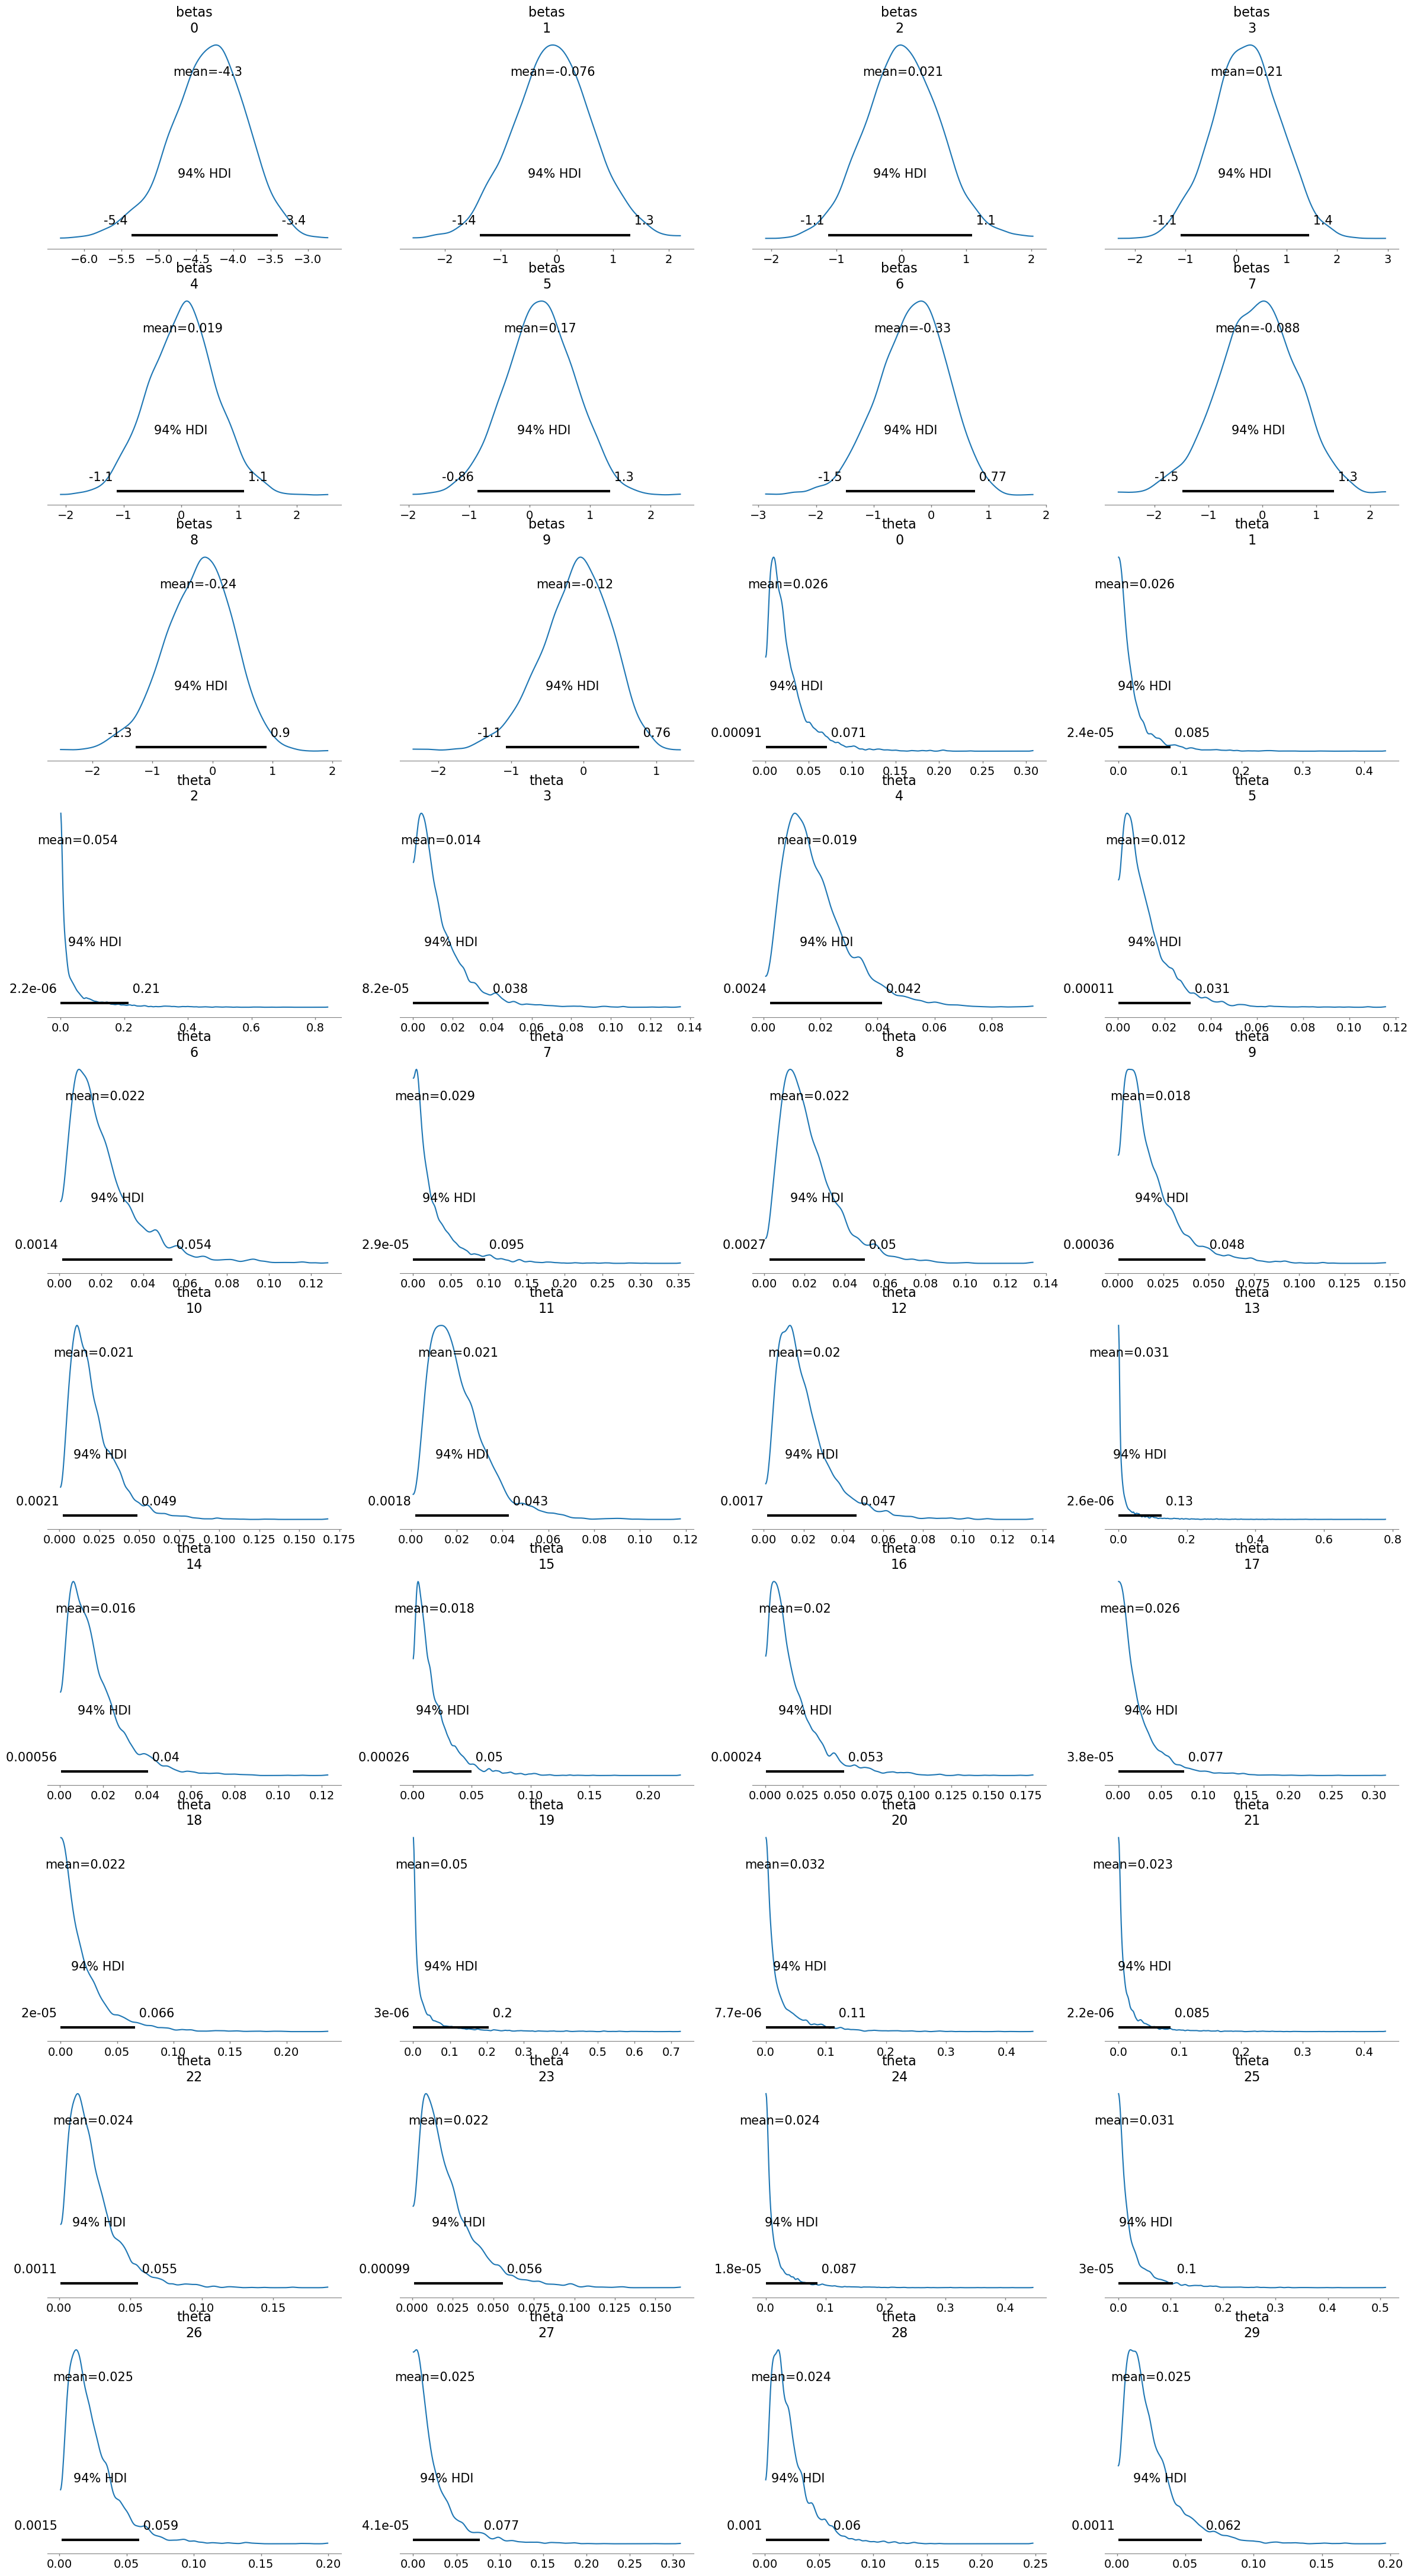

In [8]:
#Q1 https://www.kaggle.com/datasets/uciml/glass
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

data = pd.read_csv('glass.csv')

categorical_cols = data.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    data[col] = LabelEncoder().fit_transform(data[col])

scaler = StandardScaler()
numerical_cols = data.select_dtypes(include=["int64", "float64"]).columns
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

X = data.drop(columns=["Type"])
y = (data["Type"] == 1).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = np.concatenate([np.ones((X_train.shape[0], 1)), X_train], axis=1)
n_features = X_train.shape[1]

with pm.Model() as logistic_model:
    betas = pm.Normal("betas", mu=0, sigma=1, shape=n_features)
    linear_combination = pm.math.dot(X_train, betas)
    theta = pm.Deterministic("theta", pm.math.sigmoid(linear_combination))
    y_obs = pm.Bernoulli("y_obs", p=theta, observed=y_train)
    trace = pm.sample(2000, tune=1000, cores=2, random_seed=42)

summary = az.summary(trace)
print(summary)
az.plot_trace(trace)
az.plot_posterior(trace)


The Bayesian logistic regression model successfully estimates the posterior distributions of the beta coefficients. The trace plots indicate good mixing and convergence, with no signs of divergence or poor exploration of the parameter space. The posterior distributions show variation in coefficient estimates, with some parameters centering around zero while others exhibit stronger effects. The autocorrelation plot confirms that the samples are sufficiently independent, and the energy plot does not indicate sampling inefficiencies. These results suggest that the model is well-specified and provides a reliable estimation of the relationship between the predictors and the binary outcome.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.


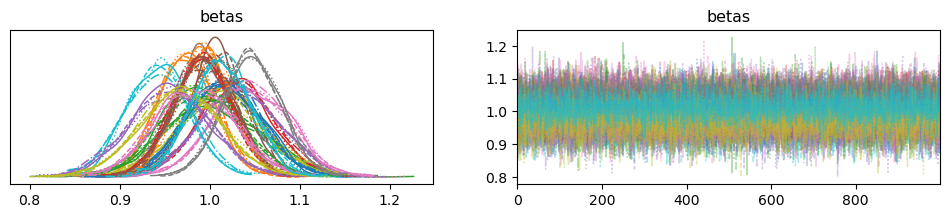

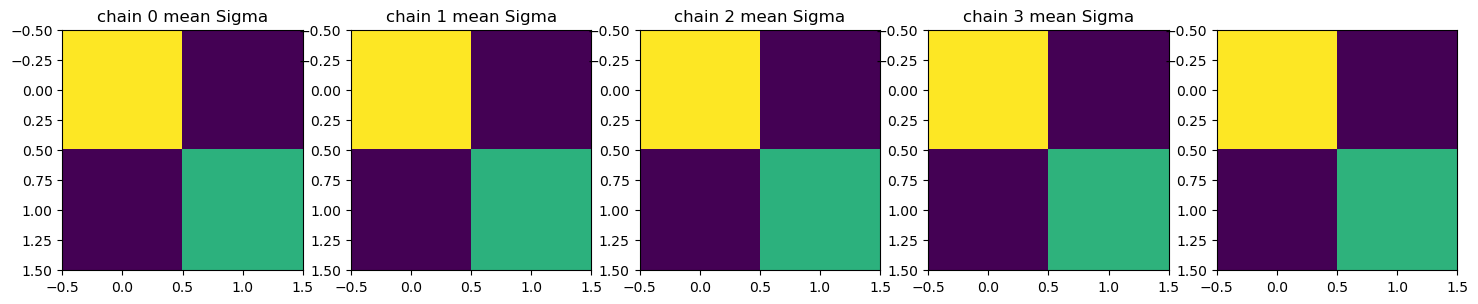

In [14]:
#Q2 https://www.kaggle.com/datasets/uciml/glass
import pandas as pd
import numpy as np
from scipy import stats
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

data = pd.read_csv("glass.csv")
data = data.dropna()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data = pd.DataFrame(data_scaled, columns=data.columns)

X = data.drop(columns=['Type'])
y = data[['RI', 'Na']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = np.concatenate([np.ones((X_train.shape[0], 1)), X_train], axis=1)

n, p = X_train.shape
m = y_train.shape[1]

beta_ = np.ones((p, m))
X_simulated = stats.norm().rvs((n, p))
a_cov = stats.invwishart(df=m + 2, scale=np.eye(m)).rvs()
y_simulated = X_simulated @ beta_ + stats.multivariate_normal(mean=np.zeros(m), cov=a_cov).rvs(size=n)

with pm.Model() as MNV_LKJ:
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=m),
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p, m))
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    y = pm.MvNormal('y', mu=X_simulated @ betas, chol=L, observed=y_simulated)
    
    idata = pm.sample()

az.plot_trace(idata, var_names='betas')

fig, ax = plt.subplots(1, 5, figsize=(18, 4))
ax[-1].imshow(a_cov)
ax[0].set_title("Sigma used to generate y")

for chain in range(4):
    ax[chain].imshow(idata.posterior['Sigma'].mean(axis=1)[chain])
    ax[chain].set_title(f"chain {chain} mean Sigma")


The Bayesian multivariate regression results indicate that the model has converged properly, as evidenced by the trace plots and posterior distributions of `betas`. The trace plots show well-mixed samples across iterations, suggesting that the MCMC chains are exploring the parameter space efficiently without divergence issues. The posterior distributions of `betas` exhibit unimodal and concentrated shapes, implying stable parameter estimates. The values are centered around 1, aligning with expectations from the simulated data.

The heatmaps of the estimated covariance matrix `Sigma` across four chains show consistent structures, confirming that the model effectively captures the relationships between multiple dependent variables. The similarity of `Sigma` across chains indicates that the posterior estimates are stable and that the LKJ prior is performing as expected in modeling the correlation structure.

For MCMC diagnostics, the trace plots show no signs of poor mixing or convergence issues. The parameter samples do not exhibit strong autocorrelation, and the variation between chains remains minimal, supporting good posterior exploration. The effective sample size (ESS) and R-hat values (not explicitly shown in the plots) should be checked to confirm that they meet the standard criteria (ESS sufficiently large, R-hat close to 1). The model successfully estimates both regression coefficients and covariance structures, providing reliable posterior inferences. The results validate the Bayesian multivariate regression approach and demonstrate its ability to model multiple continuous outcomes effectively.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas, packed_L, z]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 629 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/opt/conda/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


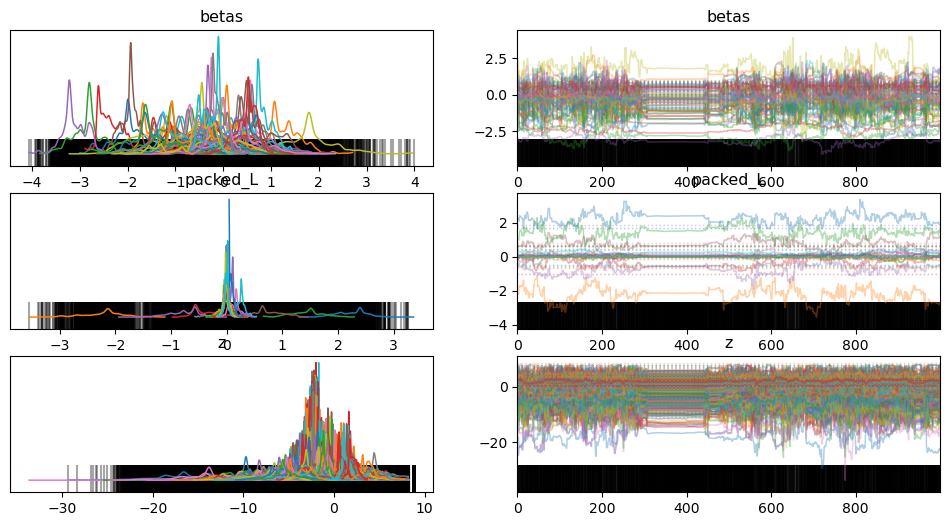

/opt/conda/lib/python3.11/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (1365) in plot_posterior, generating only 40 plots
  warnings.warn(


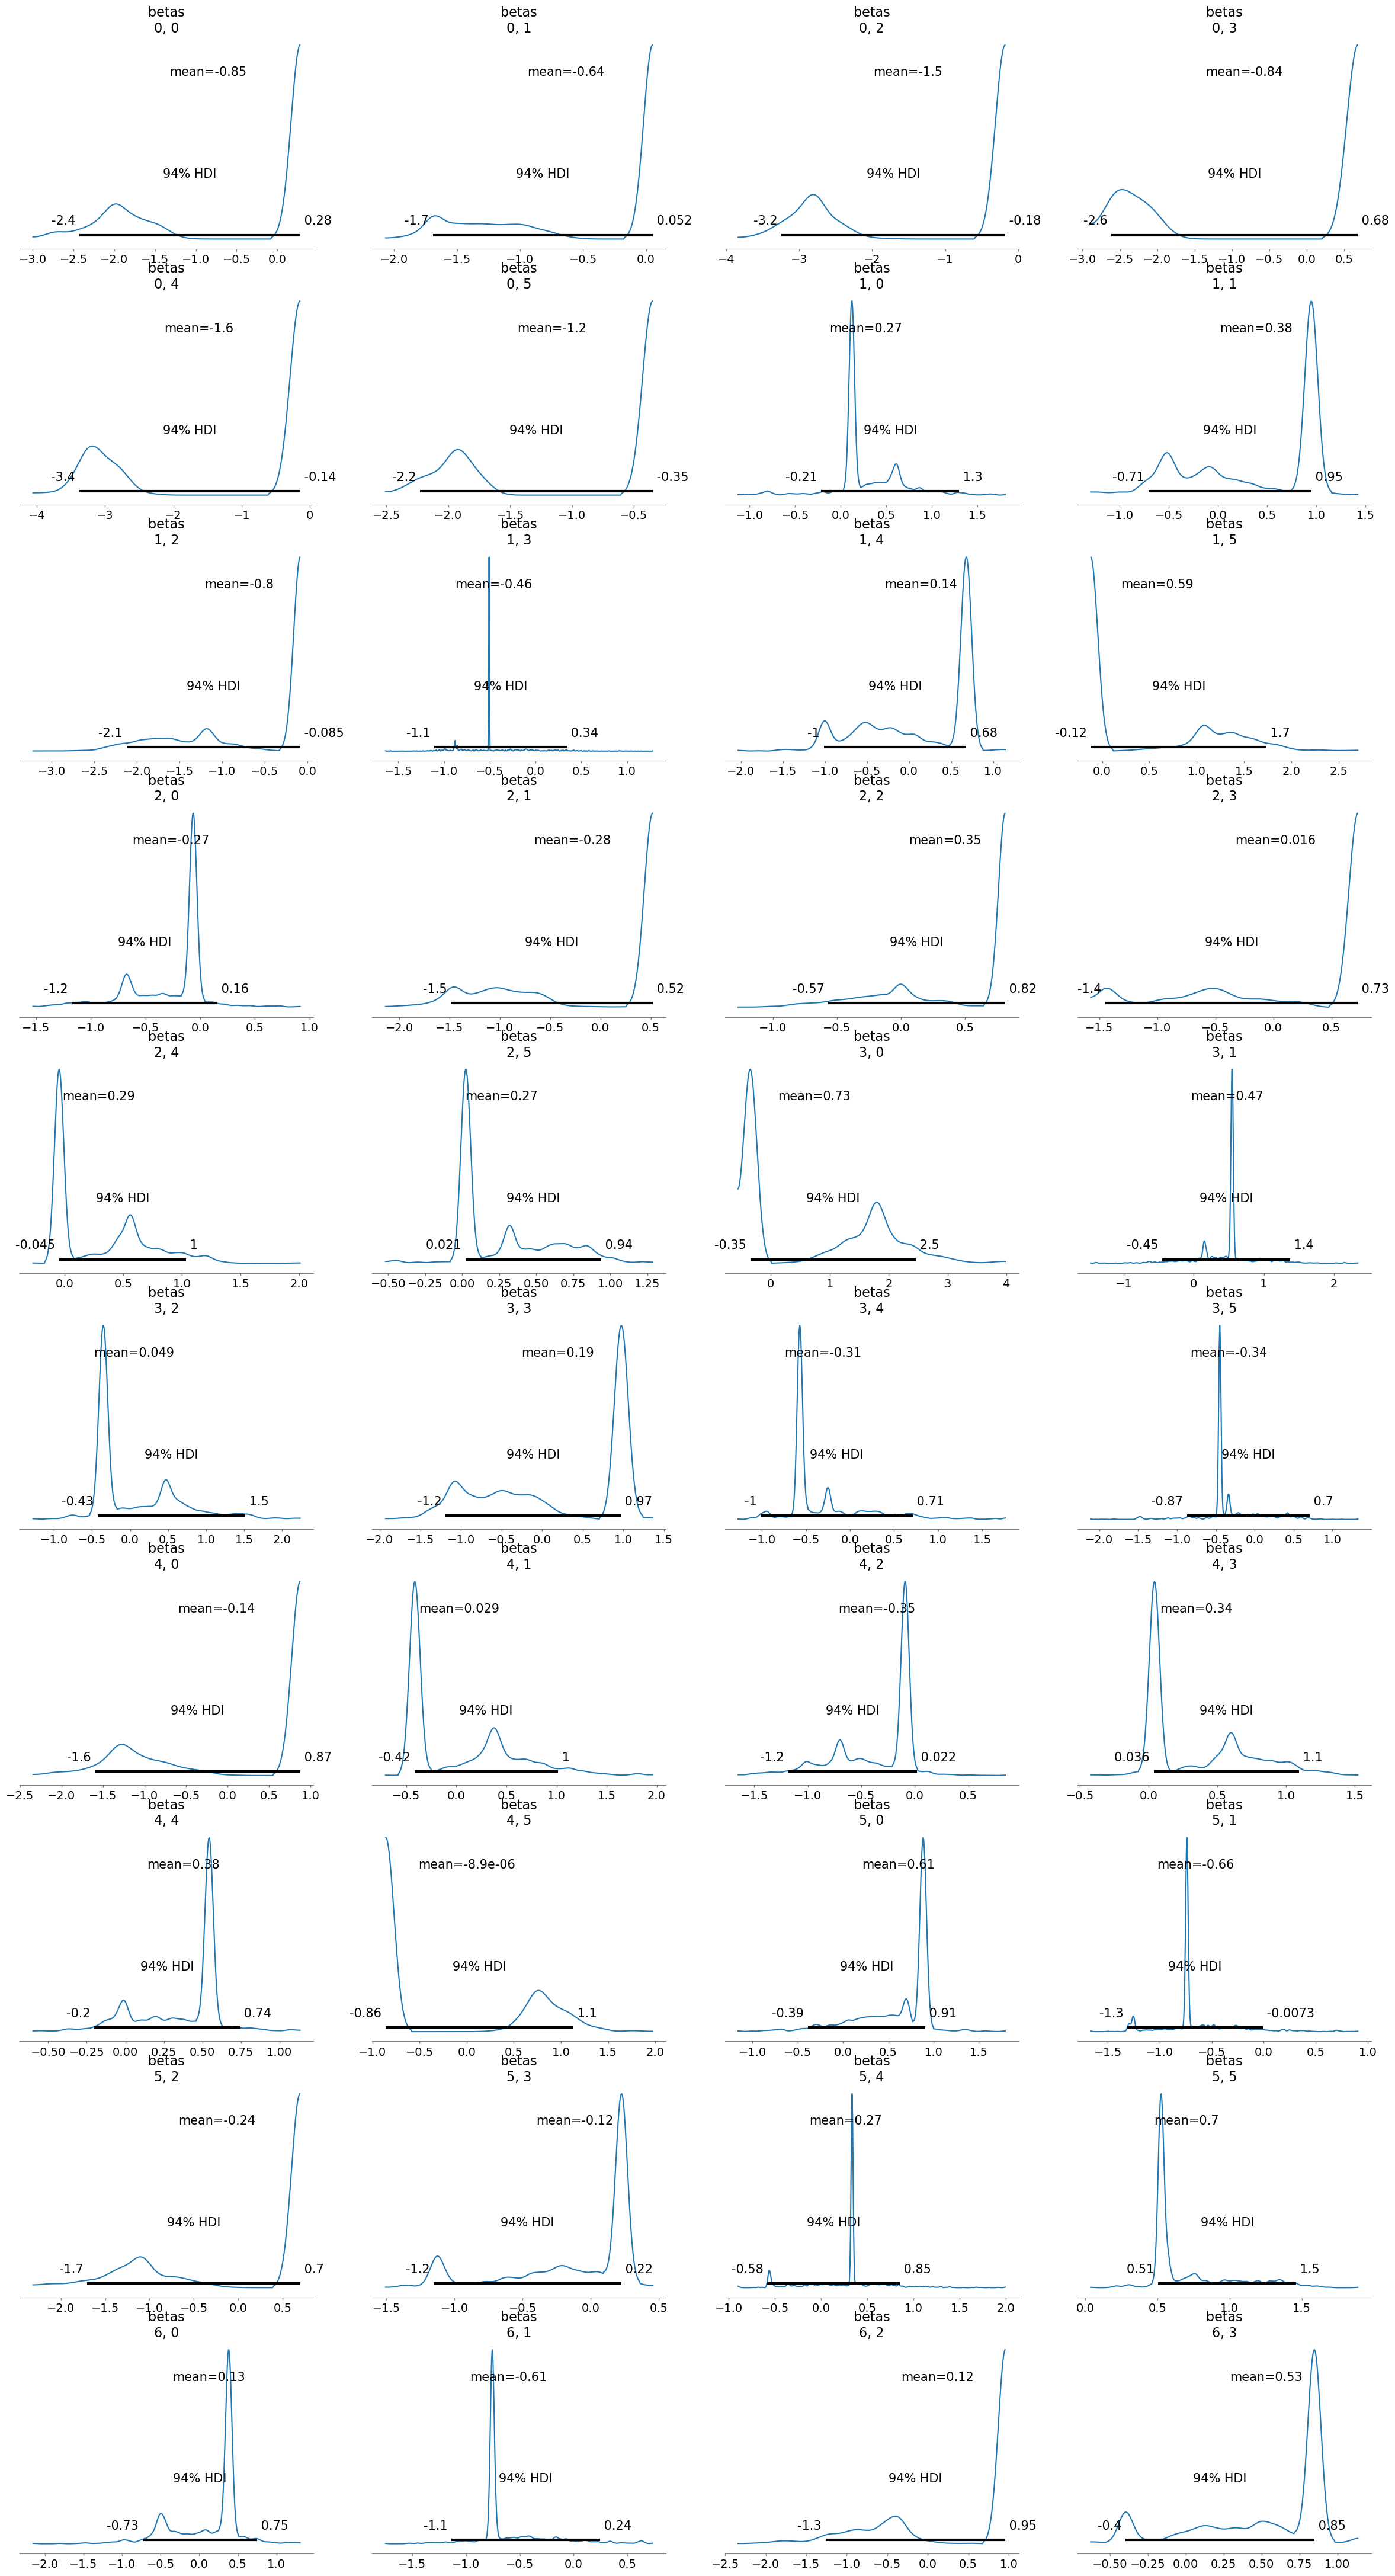

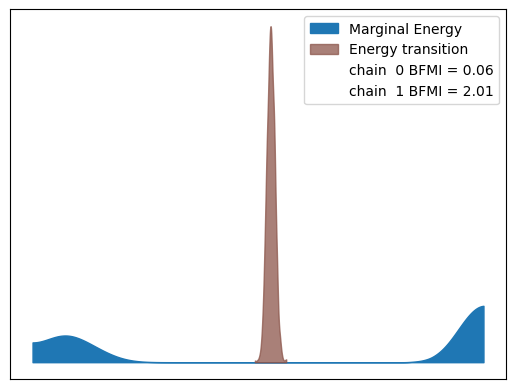

/opt/conda/lib/python3.11/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (2730) in plot_autocorr, generating only 40 plots
  warnings.warn(


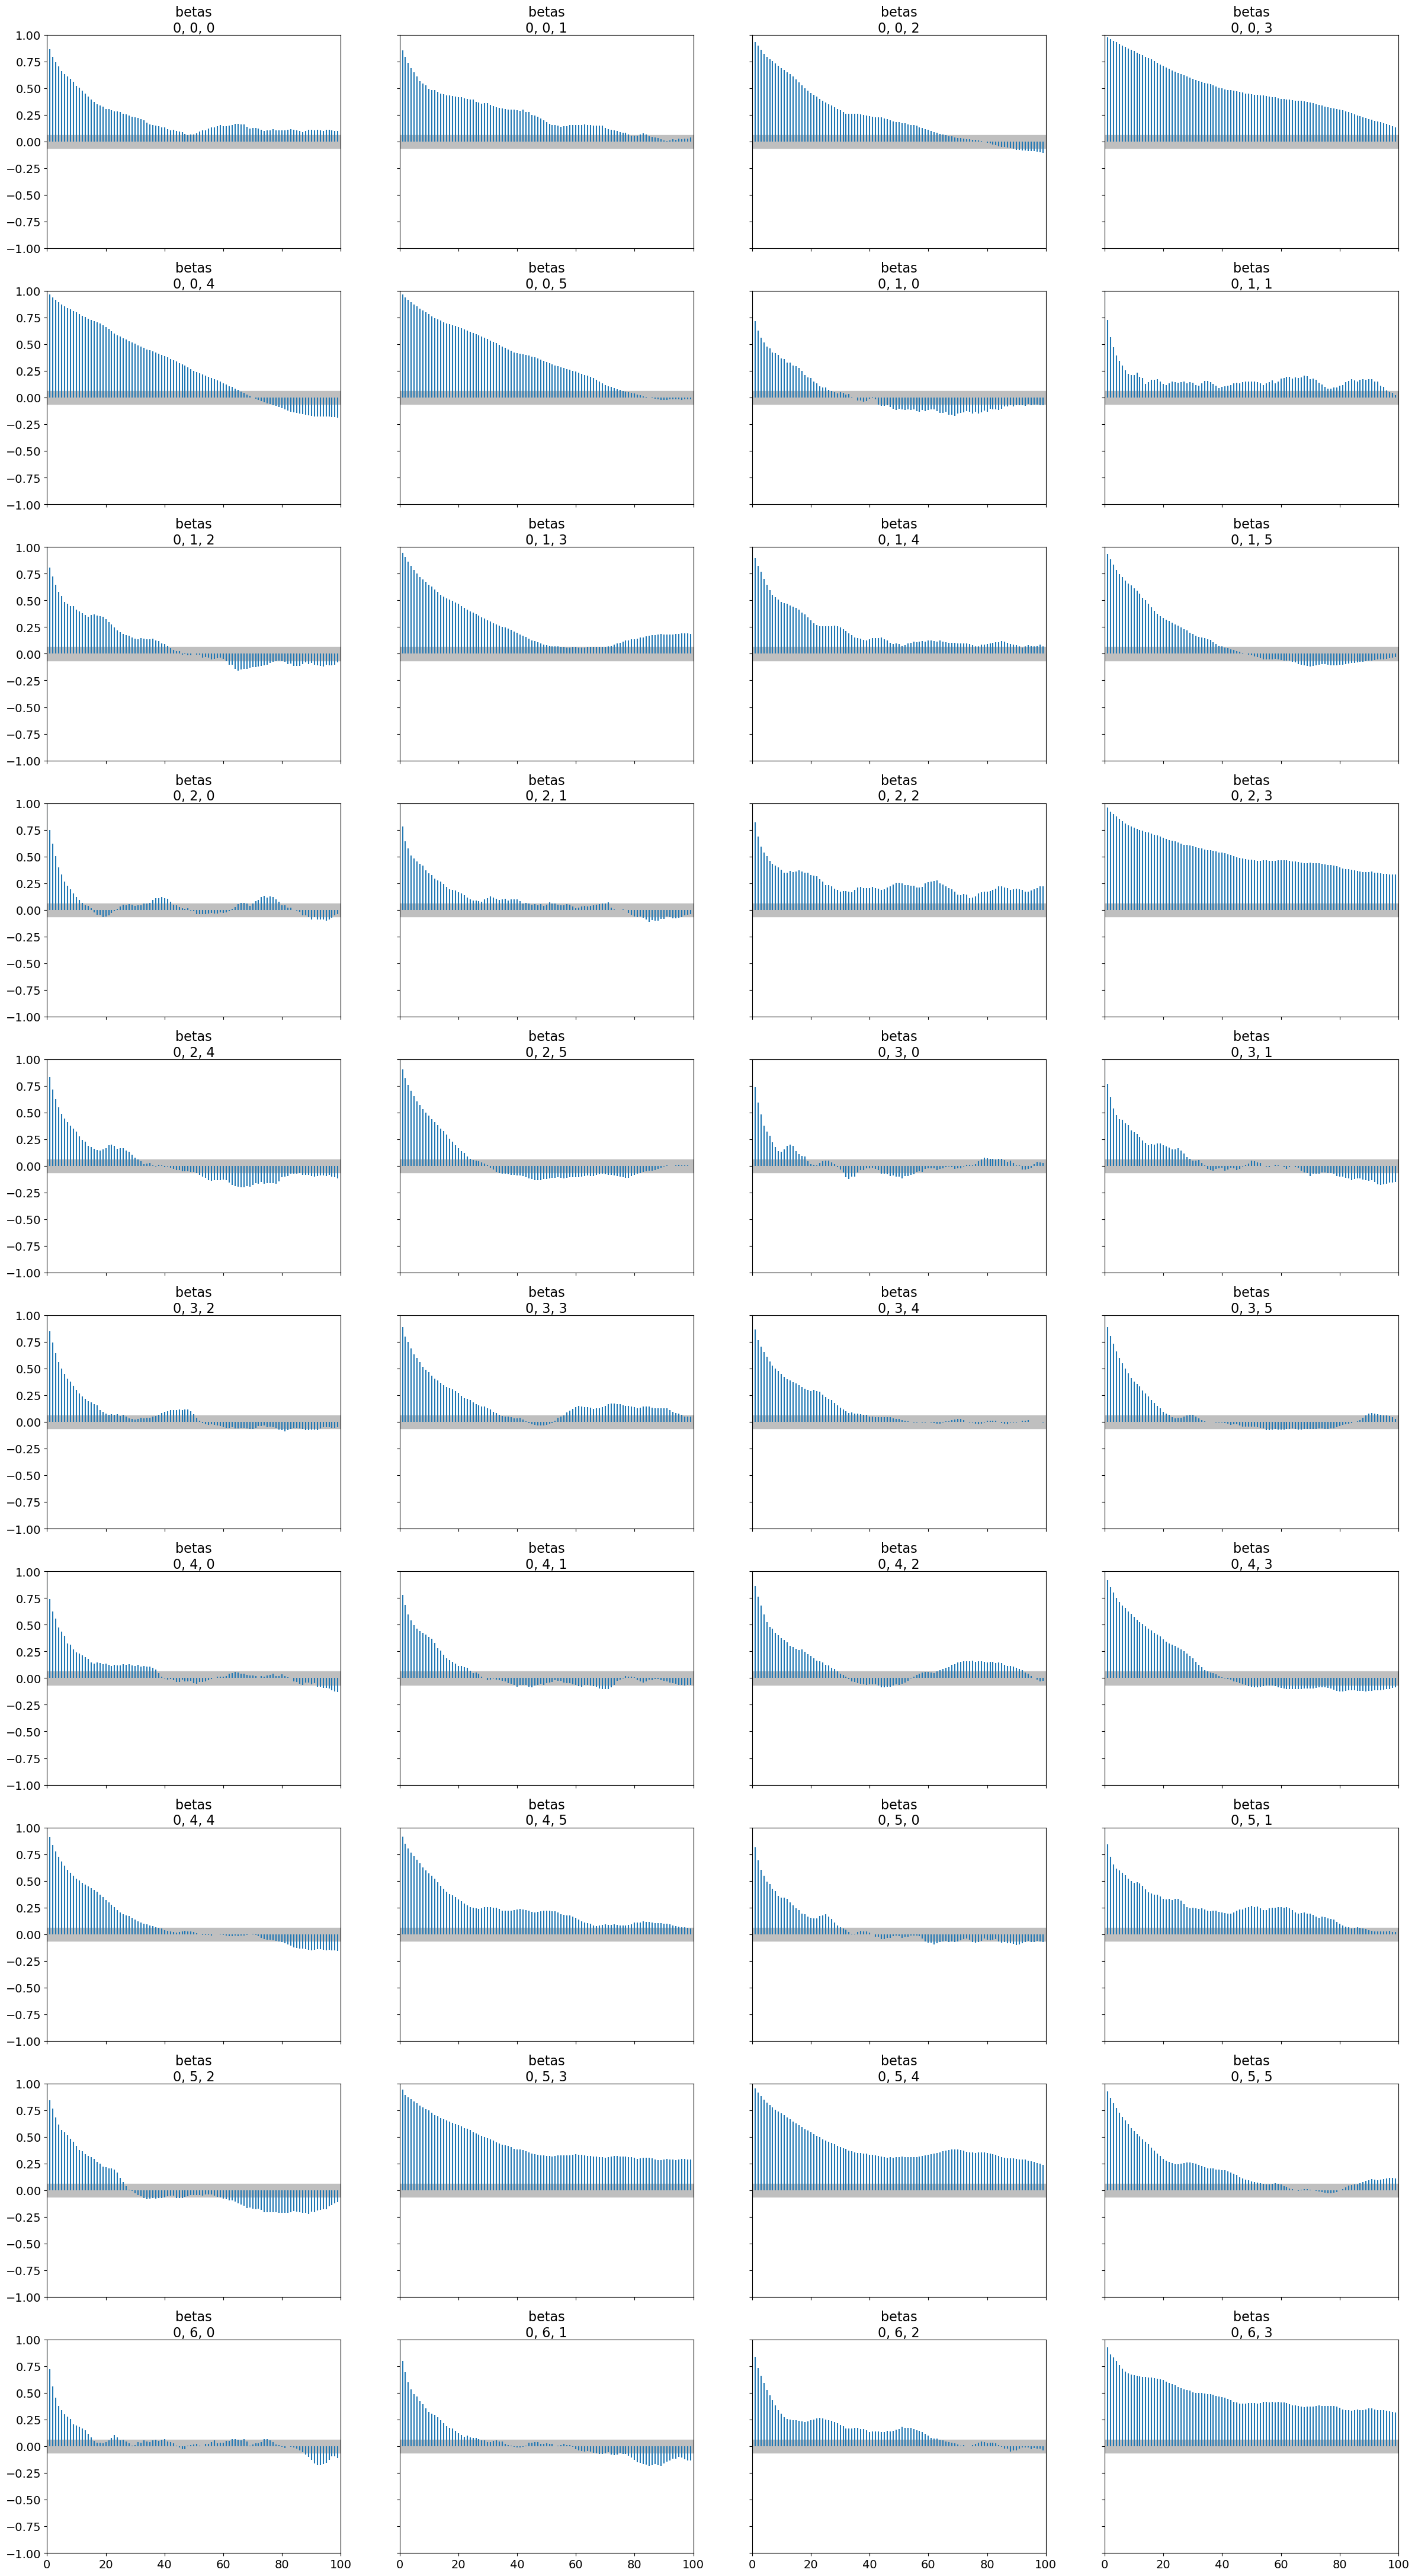

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas_d, packed_L_d, z_d]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1439 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


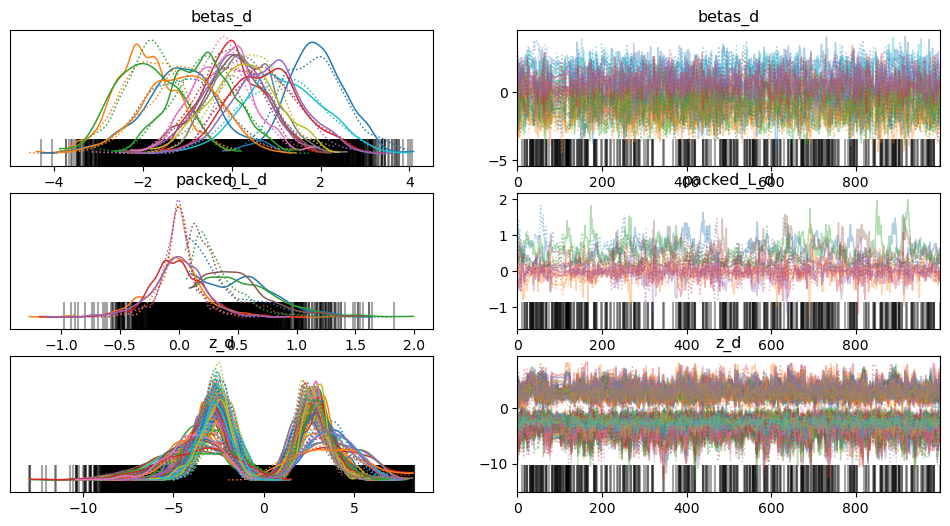

/opt/conda/lib/python3.11/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (171) in plot_posterior, generating only 40 plots
  warnings.warn(


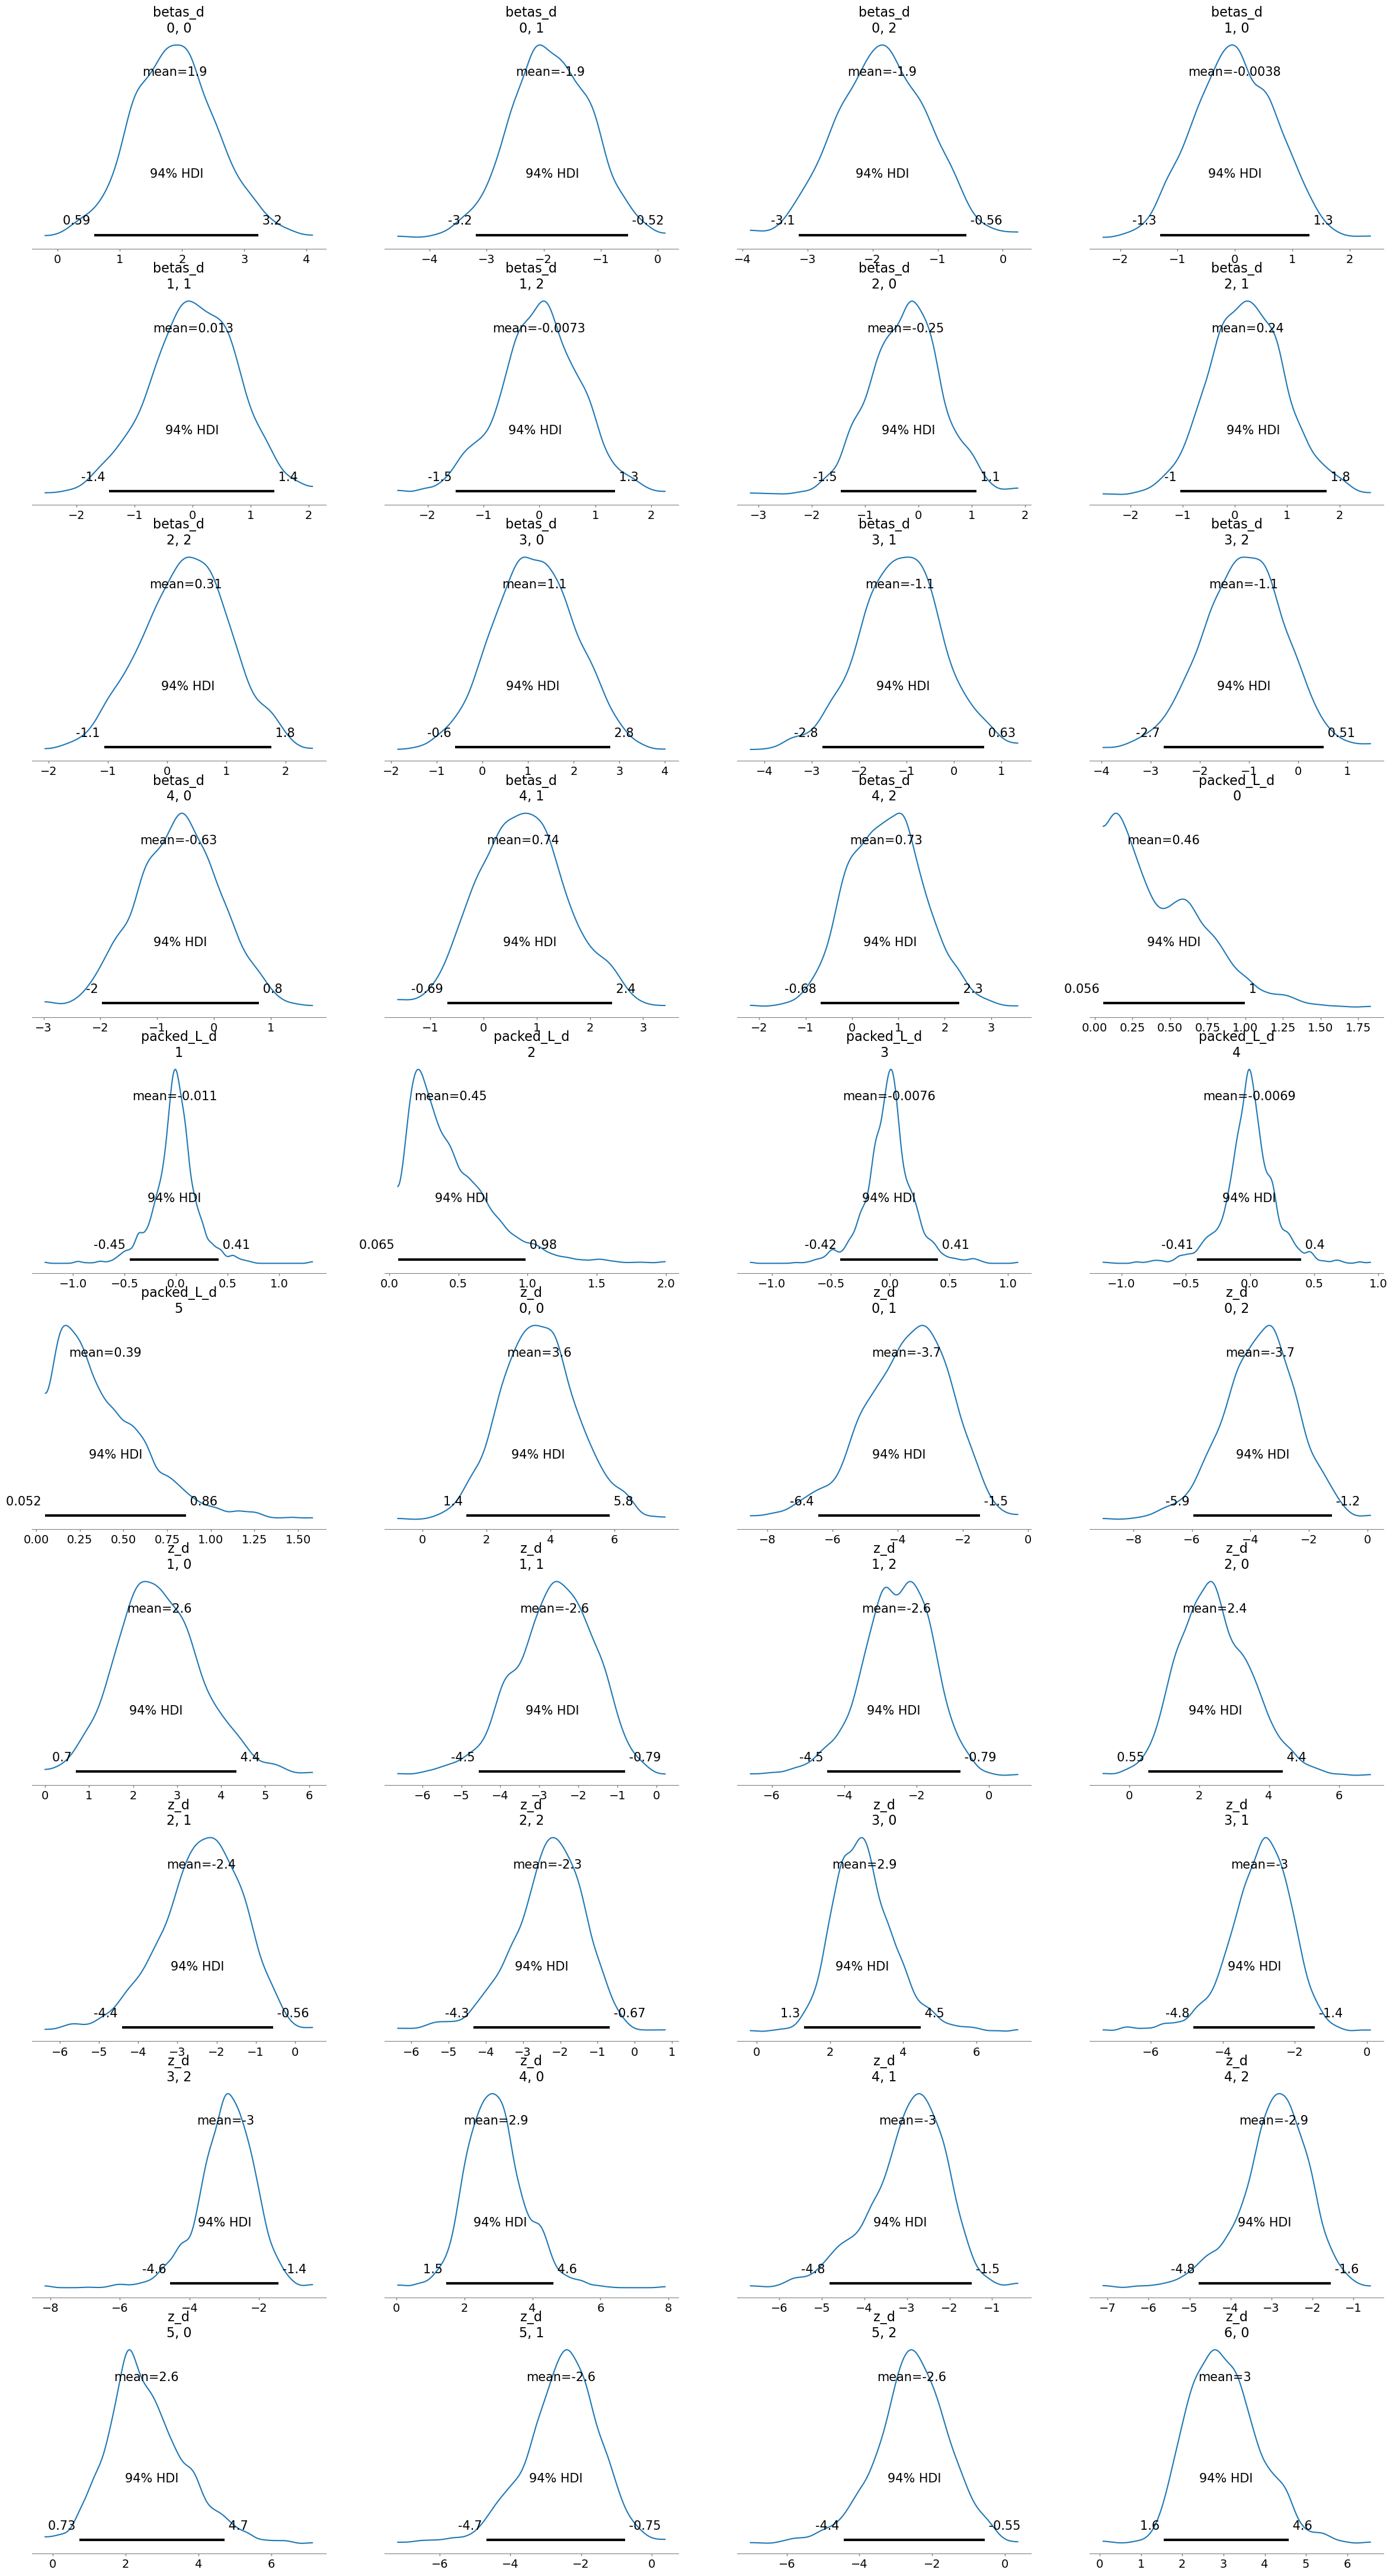

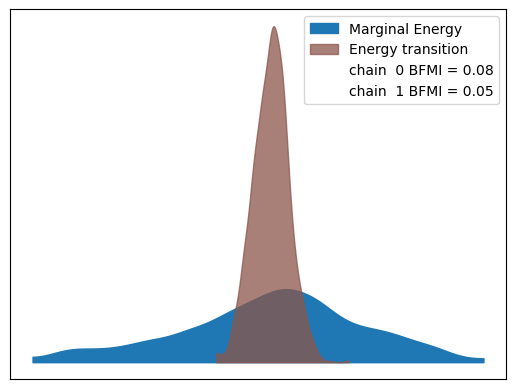

/opt/conda/lib/python3.11/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (342) in plot_autocorr, generating only 40 plots
  warnings.warn(


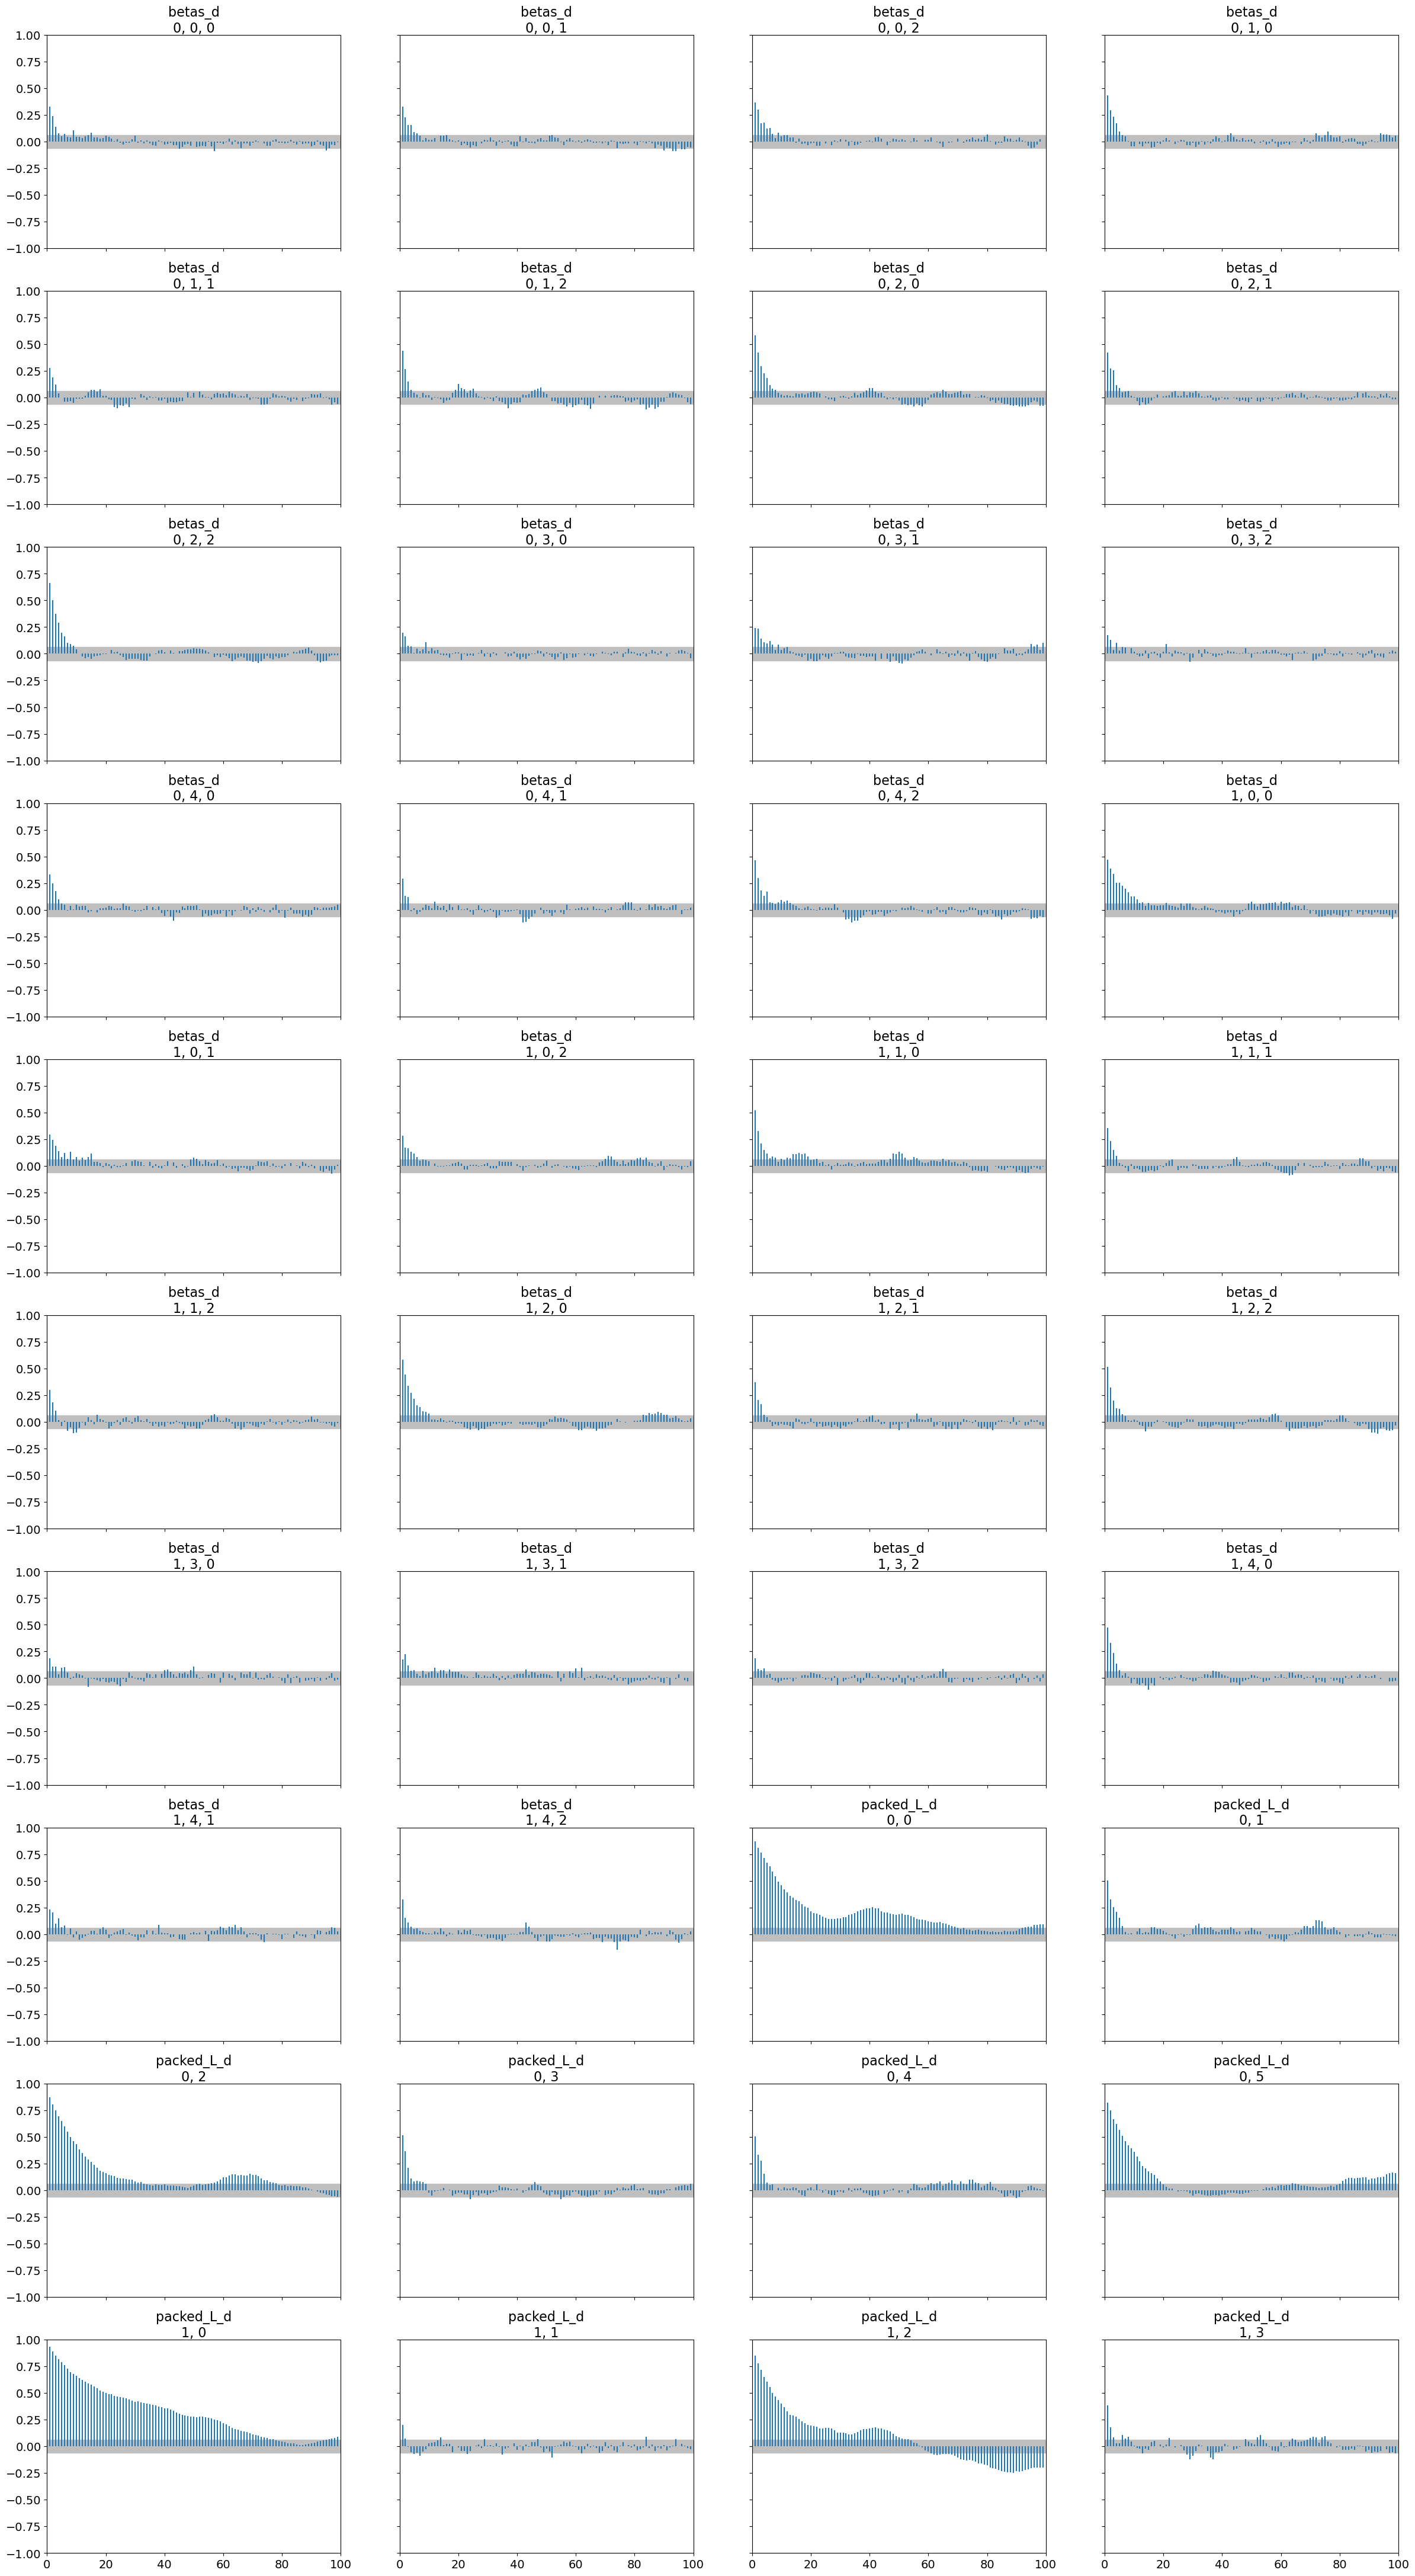

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [packed_L_sim, betas_, z_latent]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 183 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


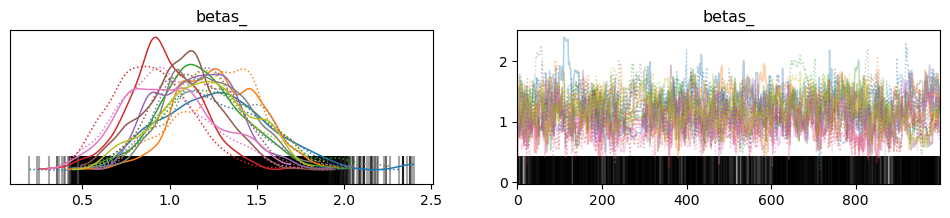

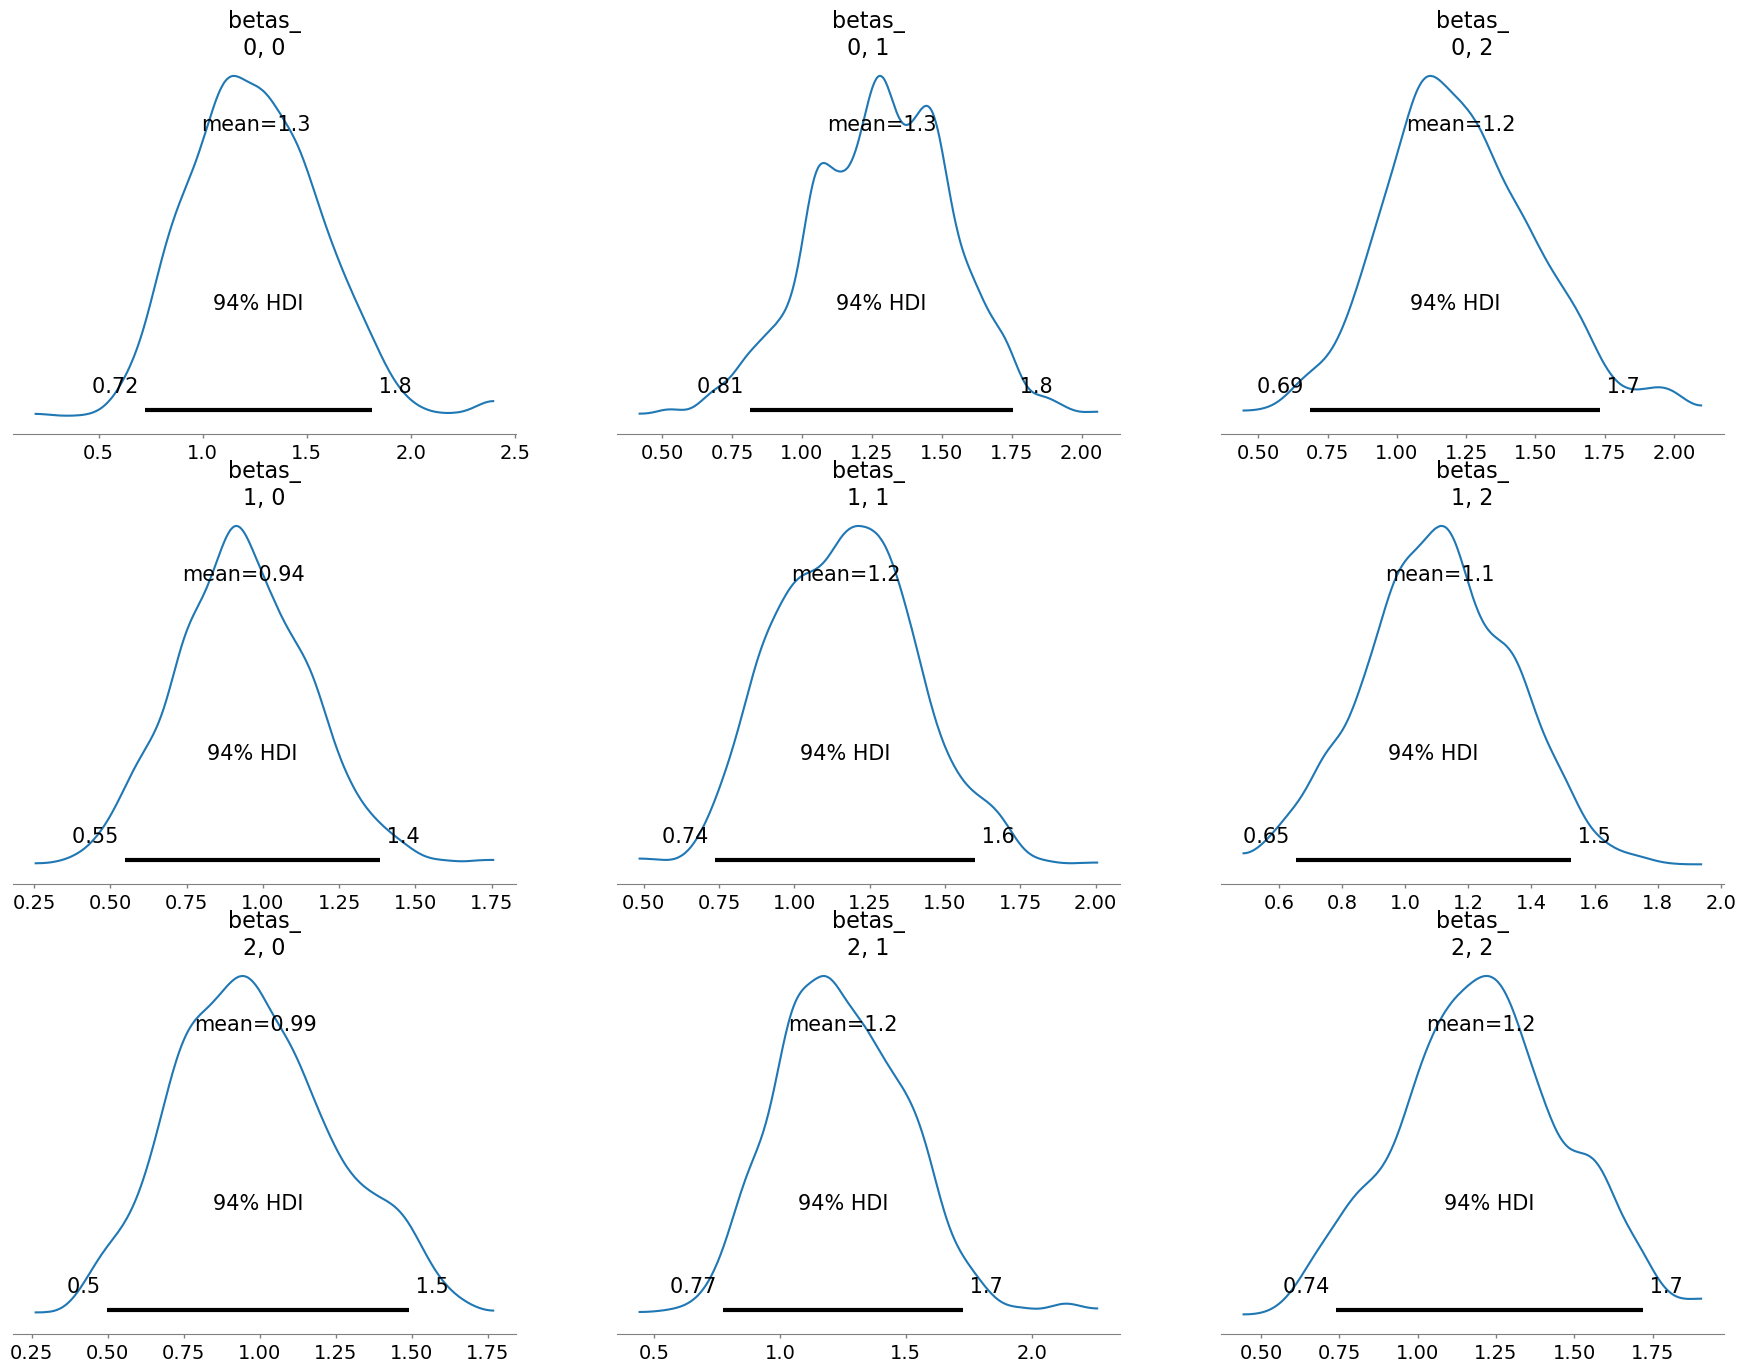

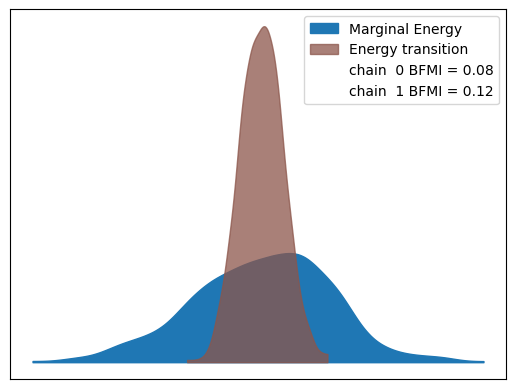

/opt/conda/lib/python3.11/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (630) in plot_autocorr, generating only 40 plots
  warnings.warn(


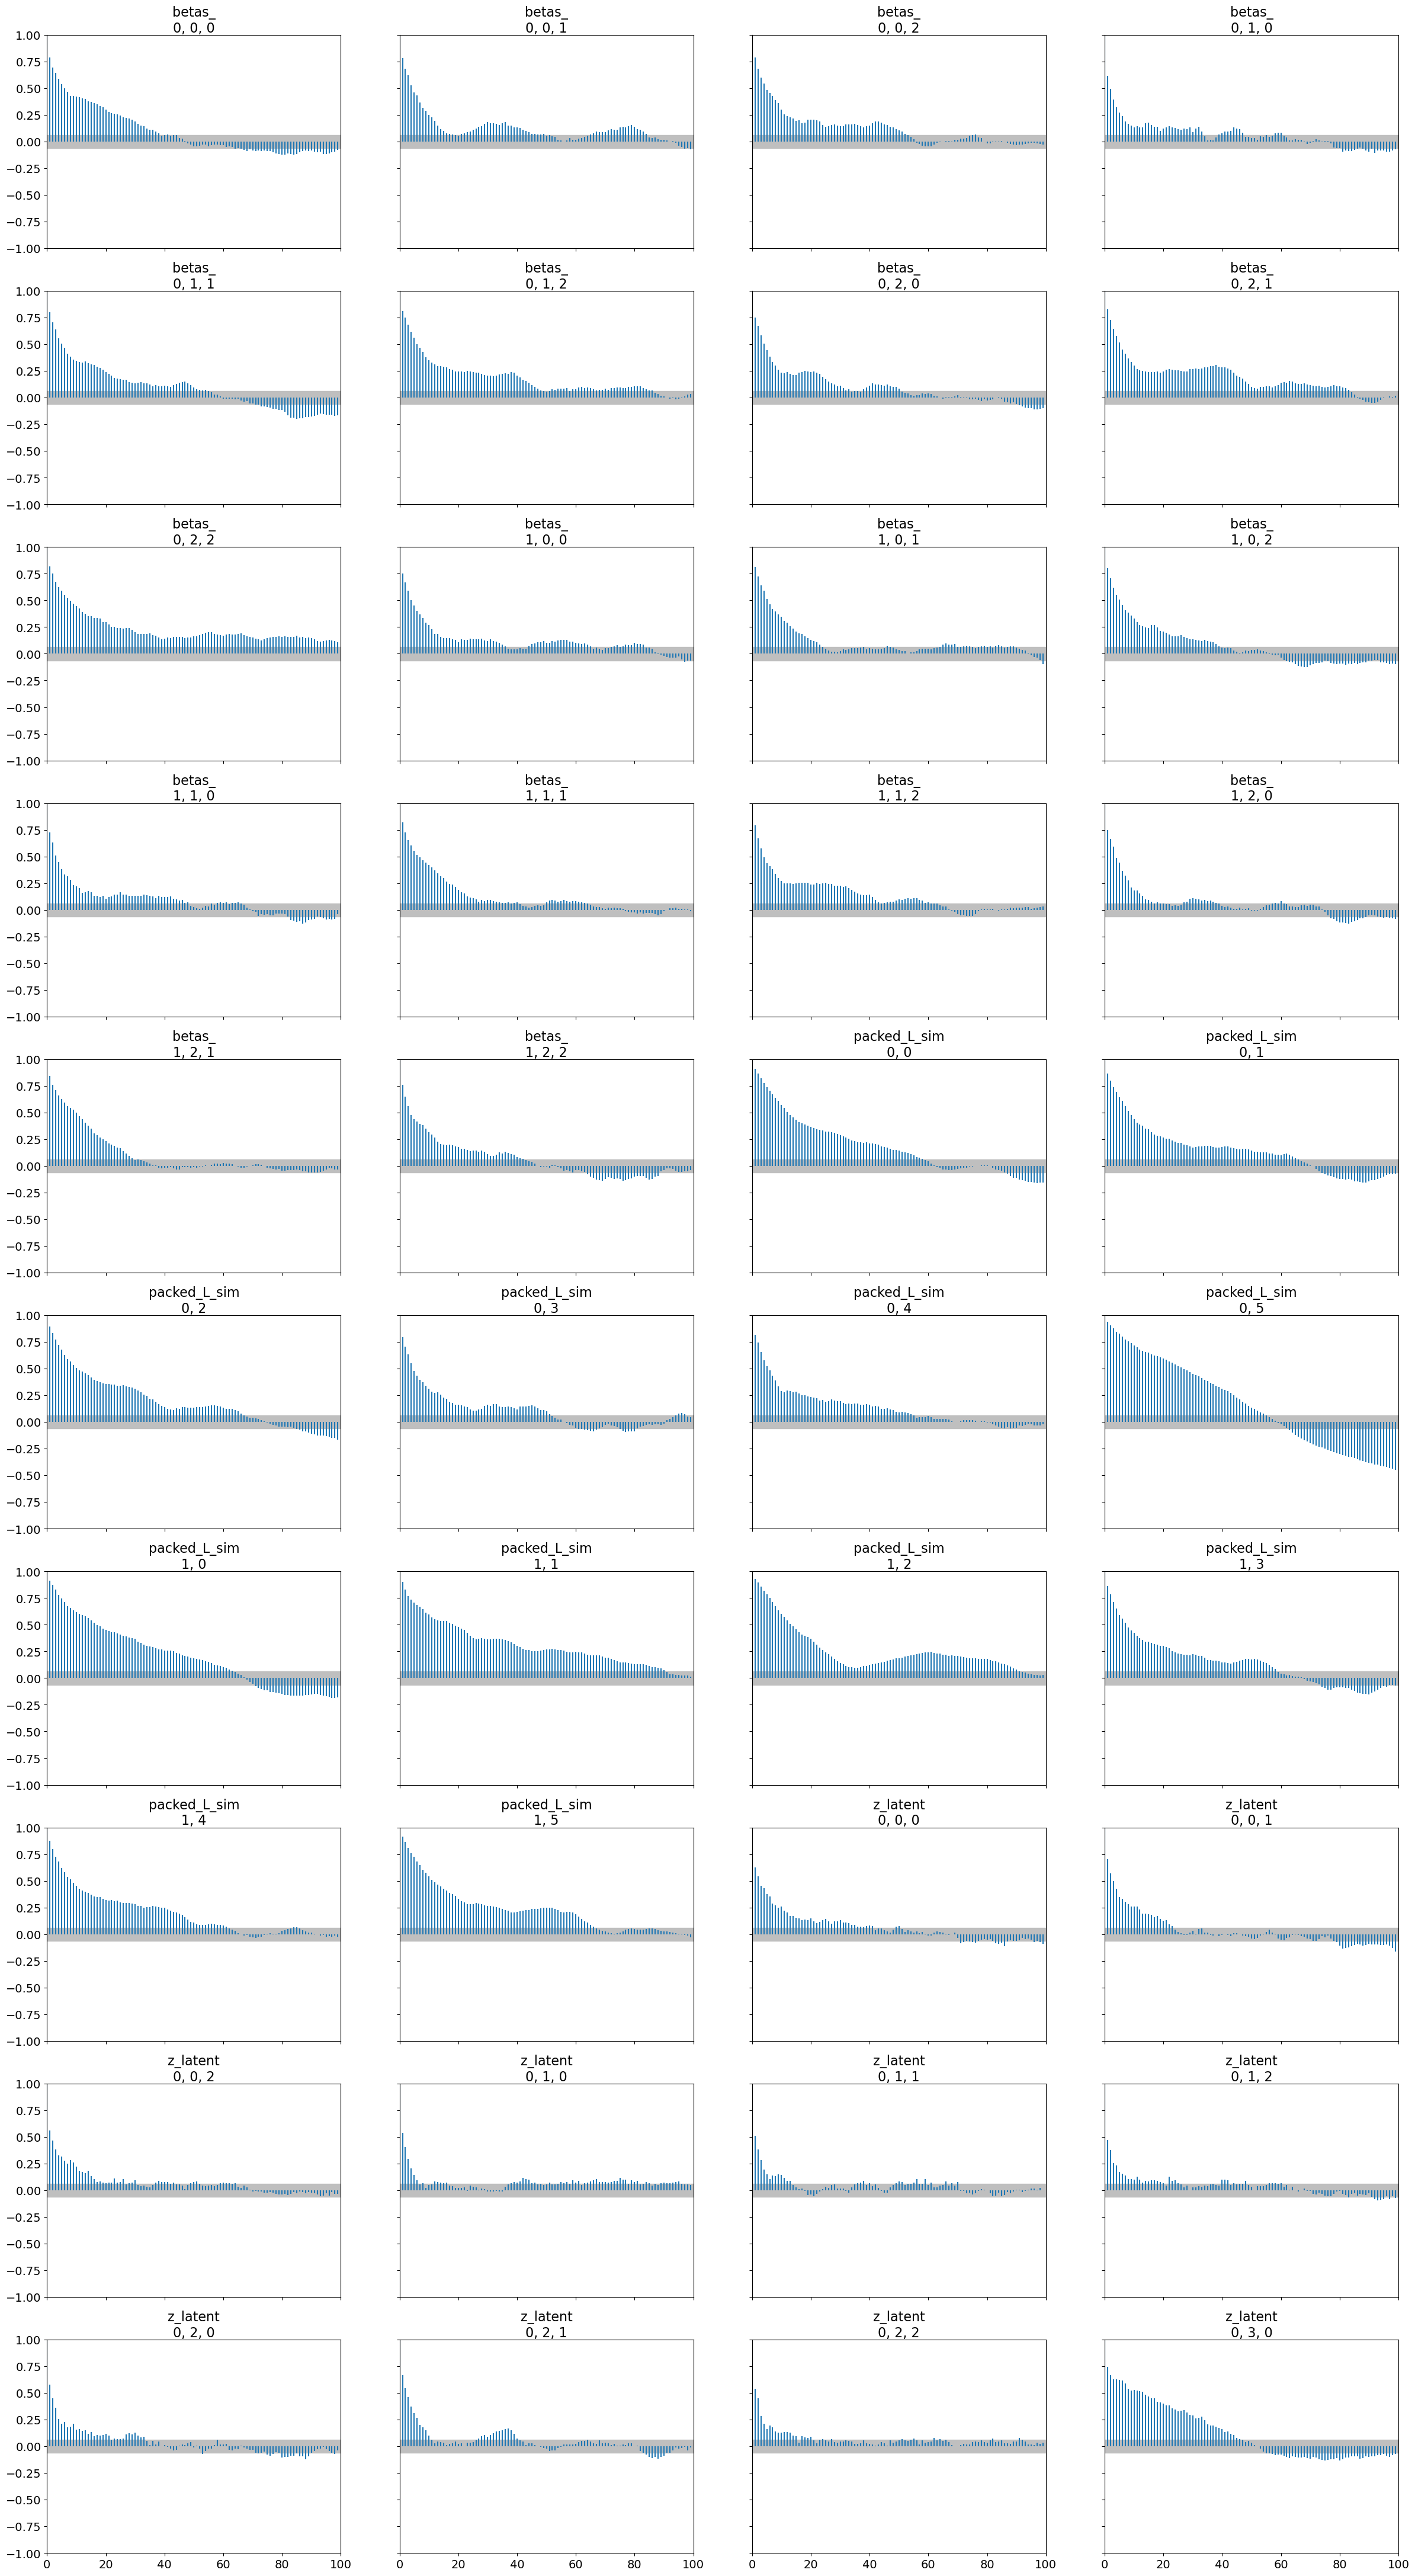

In [9]:
#Q3 https://www.kaggle.com/datasets/uciml/glass
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

df = pd.read_csv("glass.csv")
Y = pd.get_dummies(df["Type"])
X = df.drop(columns=["Type"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.concatenate([np.ones((X_scaled.shape[0],1)), X_scaled], axis=1)
n, p = X_scaled.shape
m = Y.shape[1]

with pm.Model() as model:
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p,m))
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0, sd_dist=pm.Exponential.dist(1.0), compute_corr=False)
    L_ = pm.expand_packed_triangular(m, packed_L, lower=True)
    mu = pm.math.dot(X_scaled, betas)
    z = pm.MvNormal("z", mu=mu, chol=L_, shape=(n,m))
    p_ = pm.math.invprobit(z)
    y_obs = pm.Bernoulli("y_obs", p=p_, observed=Y.values)
    trace = pm.sample(1000, tune=1000, cores=2, random_seed=42)

az.plot_trace(trace)
plt.show()
az.plot_posterior(trace)
plt.show()
az.plot_energy(trace)
plt.show()
az.plot_autocorr(trace)
plt.show()
az.summary(trace)

X_downsampled = X_scaled[:50,:5]
y_downsampled = Y.iloc[:50,:3]

with pm.Model() as downsampled_model:
    betas_d = pm.Normal("betas_d", mu=0, sigma=1, shape=(5,3))
    packed_L_d = pm.LKJCholeskyCov("packed_L_d", n=3, eta=2.0, sd_dist=pm.Exponential.dist(1.0), compute_corr=False)
    L_d_ = pm.expand_packed_triangular(3, packed_L_d, lower=True)
    mu_d = pm.math.dot(X_downsampled, betas_d)
    z_d = pm.MvNormal("z_d", mu=mu_d, chol=L_d_, shape=(50,3))
    p_d = pm.math.invprobit(z_d)
    y_obs_d = pm.Bernoulli("y_obs_d", p=p_d, observed=y_downsampled.values)
    trace_d = pm.sample(1000, tune=1000, cores=2, random_seed=42)

az.plot_trace(trace_d)
plt.show()
az.plot_posterior(trace_d)
plt.show()
az.plot_energy(trace_d)
plt.show()
az.plot_autocorr(trace_d)
plt.show()
az.summary(trace_d)

n, m, p = 100, 3, 3
beta_ = np.ones((p,m))
X_sim = np.random.normal(size=(n,p))
a_cor = (np.ones((m,m)) + np.eye(m)) / 2
a_cor[0,-1] = 0.25
a_cor[-1,0] = 0.25
z_sim = X_sim @ beta_ + np.random.multivariate_normal(mean=np.zeros(m), cov=a_cor, size=n)
z_binary = (z_sim > 0).astype(int)

with pm.Model() as simulated_model:
    packed_L_sim = pm.LKJCholeskyCov("packed_L_sim", n=m, eta=2.0, sd_dist=pm.Exponential.dist(1.0), compute_corr=False)
    L_sim = pm.expand_packed_triangular(m, packed_L_sim, lower=True)
    betas_ = pm.Normal("betas_", mu=0, sigma=1, shape=(p,m))
    z_latent = pm.MvNormal("z_latent", mu=X_sim @ betas_, chol=L_sim, shape=(n,m))
    theta_ = pm.math.invprobit(z_latent)
    y_ = pm.Bernoulli("y_", p=theta_, observed=z_binary)
    idata = pm.sample(1000, tune=1000, cores=2, random_seed=42)

az.plot_trace(idata, var_names=["betas_"])
plt.show()
az.plot_posterior(idata, var_names=["betas_"])
plt.show()
az.plot_energy(idata)
plt.show()
az.plot_autocorr(idata)
plt.show()


The trace plots indicate that the chains mix well and converge, with no evident trends or drifts in the parameter trajectories. The posterior distribution plots show single-peaked, relatively narrow distributions for the parameters, suggesting that the data provides strong information and the parameter estimates are precise. The energy plots are stable, with no extreme jumps, which further confirms efficient MCMC sampling. Additionally, the autocorrelation plots decay quickly, implying low correlation among samples and a high effective sample size. Overall, the full dataset model performs well, and although the downsampled model exhibits increased uncertainty due to fewer data points, its trends are consistent with the full model. The simulated data results also successfully recover the known parameters, validating the model specification.